In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms

torch.manual_seed(1)

In [2]:
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.4.0


In [3]:
mnist_data = datasets.MNIST("./mnist_data", train=True, download=True)

In [4]:
mnist_data[0][0]

In [5]:
mnist_data[0][1]

5

In [6]:
# apply transforms to MNIST
mnist_data = datasets.MNIST("./mnist_data", train=True, download=True,
                    transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))

In [7]:
mnist_data[0][0].shape

torch.Size([1, 28, 28])

the general architecture of CNN is: INPUT -> [[CONV -> RELU] * N -> POOL] * M -> [FC -> RELU]*K -> FC

In [8]:
# normalize the whole dataset (doable only for small dataset)
data = [mnist_data[0][0].cpu().numpy() for d in mnist_data]

In [9]:
np.mean(data)

0.1376811

In [10]:
np.std(data)

0.3123489

In [11]:
# apply transforms to MNIST
# P.S. datasets.FashionMNIST can be used in the same way
mnist_data = datasets.MNIST("./mnist_data", train=True, download=True,
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1376,), (0.3123,))
                   ]))

In [12]:
# prepare dataloader
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = test_batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [13]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5) # (in_channel, out_channel, kernel size)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        '''
        x : (batch, 1, 28, 28)
        '''
        x = F.relu(self.conv1(x)) # (batch, 20, 24, 24)
        x = F.max_pool2d(x, 2, 2) # (batch, 20, 12, 12)
        x = F.relu(self.conv2(x)) # (batch, 50, 8, 8)
        x = F.max_pool2d(x, 2, 2) # (batch, 50, 4, 4)
        x = x.view(-1, 50*4*4)
        x = F.relu(self.fc1(x)) # (batch, 500)
        x = self.fc2(x) # (batch, 10)
        return F.log_softmax(x, dim=1) # (batch, 10)

In [14]:
lr = 0.01
momentum = 0.5
model = Simple_CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [15]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target) # for multi-class classification, negative log likelihood (given output from log_softmax) is equivalent to cross entropy loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {}, iteration: {}, Loss: {}".format(epoch, batch_idx, loss.item()))

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdims=True) # (batch, 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    correct /= len(test_loader.dataset)
    
    print("Avg loss: {}, Accuracy: {}".format(test_loss, correct))

In [17]:
epochs = 2
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1, iteration: 0, Loss: 2.301285982131958
Train Epoch: 1, iteration: 100, Loss: 0.6398928165435791
Train Epoch: 1, iteration: 200, Loss: 0.15489943325519562
Train Epoch: 1, iteration: 300, Loss: 0.16877394914627075
Train Epoch: 1, iteration: 400, Loss: 0.4023624658584595
Train Epoch: 1, iteration: 500, Loss: 0.21066173911094666
Train Epoch: 1, iteration: 600, Loss: 0.20253536105155945
Train Epoch: 1, iteration: 700, Loss: 0.11697067320346832
Train Epoch: 1, iteration: 800, Loss: 0.21532654762268066
Train Epoch: 1, iteration: 900, Loss: 0.050438255071640015
Train Epoch: 1, iteration: 1000, Loss: 0.2730284035205841
Train Epoch: 1, iteration: 1100, Loss: 0.1850098818540573
Train Epoch: 1, iteration: 1200, Loss: 0.00864875316619873
Train Epoch: 1, iteration: 1300, Loss: 0.2881283760070801
Train Epoch: 1, iteration: 1400, Loss: 0.03564157336950302
Train Epoch: 1, iteration: 1500, Loss: 0.1883896291255951
Train Epoch: 1, iteration: 1600, Loss: 0.041035741567611694
Train Epoch: 1,

Transfer Learning  
- fine tunning: does not fix weights of pretrained layers
- feature extraction: fix weights of pretrained layers and only train new layers

In [18]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy

In [41]:
# apply transfer learning into hymenoptera_data dataset
data_dir = "./hymenoptera_data"
model_name = "resnet"
num_classes = 2 # ants and bees
batch_size = 32
num_epochs = 5
feature_extract = True
input_size = 224

In [20]:
# explore data
all_images = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

In [21]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
loader = torch.utils.data.DataLoader(all_images,
    batch_size=batch_size, shuffle=True, **kwargs)

In [22]:
img = next(iter(loader))

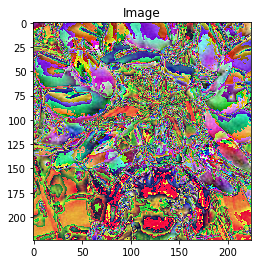

In [23]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(img[0][0], title = 'Image')

In [24]:
model_ft = models.resnet18() # resnet18 from torchvision

In [25]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
model_ft.fc.in_features

512

In [27]:
def set_parameter_requires_grad(model, feature_extract):
    # freaze weight on feature_extract
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained = use_pretrained) # resnet18 from torchvision
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_features, num_classes)
        input_size = 224
    else:
        print("model not implemented")
        return None, None
    
    return model_ft, input_size

In [28]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [29]:
model_ft.fc.weight.requires_grad

True

In [30]:
# check if parameters of layers in the front of last fc layer are freezed
model_ft.layer4[0].conv1.weight.requires_grad

False

In [31]:
input_size = 224
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# same as above, but just put train and val data into dict
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# train and val data loader
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [32]:
len(dataloaders_dict["train"].dataset.imgs)

244

In [33]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs = 5):
    
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    val_acc_history = []
    
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            
            running_loss = 0
            running_corrects = 0
            
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            # train or eval one batch at a time
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    
                    outputs = model(inputs) # (batch_size, 2)
                    loss = loss_fn(outputs, labels)
                
                preds = outputs.argmax(dim=1, keepdims=True) # (batch_size, 1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.shape[0]
                running_corrects += preds.eq(labels.view_as(preds)).sum().item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("{} Loss: {} Acc: {}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
        print()
        
    print("Best val Acc: {}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [34]:
model_ft = model_ft.to(device)

In [35]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 0.001, momentum = 0.9)

In [36]:
loss_fn = nn.CrossEntropyLoss()

In [37]:
model_ft, hist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer)

train Loss: 0.6635385702867977 Acc: 0.569672131147541
val Loss: 0.5942490615096747 Acc: 0.6470588235294118

train Loss: 0.5290494307142789 Acc: 0.7377049180327869
val Loss: 0.40759291017756744 Acc: 0.869281045751634

train Loss: 0.4094188115635856 Acc: 0.8319672131147541
val Loss: 0.3484375881992914 Acc: 0.9019607843137255

train Loss: 0.3226425579336823 Acc: 0.8934426229508197
val Loss: 0.29209025155485063 Acc: 0.9084967320261438

train Loss: 0.2681537583226063 Acc: 0.9139344262295082
val Loss: 0.2764921407489216 Acc: 0.9215686274509803

Best val Acc: 0.9215686274509803


In [38]:
# model trained from scratch
model_scratch, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
model_scratch = model_scratch.to(device)

In [39]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()
model_scratch, hist_scratch = train_model(model_scratch, dataloaders_dict, loss_fn, optimizer)

train Loss: 0.6777031626857695 Acc: 0.5778688524590164
val Loss: 0.6828961543787538 Acc: 0.6013071895424836

train Loss: 0.6746193522312602 Acc: 0.6024590163934426
val Loss: 0.6746400419403525 Acc: 0.5882352941176471

train Loss: 0.6848913020774966 Acc: 0.5737704918032787
val Loss: 0.6763389204062668 Acc: 0.5751633986928104

train Loss: 0.6973293013260012 Acc: 0.5245901639344263
val Loss: 0.6770336787685071 Acc: 0.5751633986928104

train Loss: 0.6891644294144678 Acc: 0.5532786885245902
val Loss: 0.673370998669294 Acc: 0.5882352941176471

Best val Acc: 0.6013071895424836


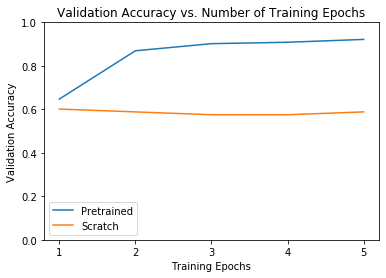

In [42]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist,label="Pretrained")
plt.plot(range(1,num_epochs+1),hist_scratch,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()